# Experiment Zero

> Acknowledgement: This work builds upon previous OCCaM lab members' work and was done in collaboration with Professor Paul Ruvolo.

## Experiment Overview
The purpose of this experiment is to understand the correlation between the primary evaluation metric (ground truth metric) and noise present in data, as well as assess the quality of Invisible Map's backend optimization and test certain hypotheses as to assumptions made on its performance in a controlled environment. This controlled environment was made by generating data sets for testing, rather than using purely real-world data. This allows us to know the position of odometry nodes and tag positions with 100% confidence, while also sweeping through potential error sources to analyze the correlation between input variance and output error. The hypothesis is that an inputted variance should directly correlate to the corresponding output error (difference in ground truth metric). For example, generating a data set with significant odometry variance should lead to an optimal map with relatively high confidence in tag detections and relatively low confidence in odometry.

Ground truth metric is an error evaluation metric that provides the average Euclidean distance between the predicted positions of the tags and their actual positions (ground truth) for each tag in the dataset. In cases where there are >1 tags present in the map, each tag is turned into an anchor tag (fixed position), and the ground truth metric is found for each tag. The average error for each of these maps is returned as the ground truth metric.

This experiment will be conducted for three different data sets and two main optimizer workflows. The three data sets will vary in size, one small data set, one medium-sized data set, and one large data set to determine any impact the map size has on input-output correlations. The two main optimizer workflows are with Sparse Bundle Adjustment and no Sparse Bundle Adjustment. 

This experiment will be conducted for 

## Data Set Simulation

The data set simulation works by iterating through a given sequence of poses and simulating tag observations at each pose. Gaussian noise can optionally be introduced into both the odometry path and the simulated observation. For a tag to be visible from a given odometry pose, it must meet three criteria:

1. Distance to the tag is under the given threshold.
2. Angle-of-attack to the tag is under the given threshold.
3. Pixel coordinates of the tag fit entirely within the sensor.

Simulated data sets can be either derived from a parametric path or from a real data set. Here, to generate a parametric path that specifies the position of the simulated phone as a function of time, a hard-coded set of tag poses must be provided, and the phone orientation is obtained via a (rotated) Frenet frame computed using a discrete derivative of the path.

## Initialization

Run the following code cell once and only once before executing other tests. This will ensure the correct working directory is set and initialize necessary variables.

In [1]:
small_data_set_name="4_lou_to_rich_room.json"
large_data_set_name="p1_WH4_2.json"
%cd ../..

/home/achakraborty/Documents/occam/invisible-map-generation


In [2]:
from map_processing.data_models import *
from map_processing.graph_generator import GraphGenerator
from map_processing import GT_TAG_DATASETS, PrescalingOptEnum
from map_processing.cache_manager import MapInfo
from map_processing.graph_opt_hl_interface import (
    WEIGHTS_DICT,
    WeightSpecifier,
)
from map_processing.sweep import sweep_params
import os
import sys

from map_processing.cache_manager import CacheManagerSingleton
from run_scripts import optimize_graphs_and_manage_cache
from map_processing.data_models import UGDataSet, GenerateParams
from map_processing.graph_generator import GraphGenerator
from map_processing import ASSUMED_TAG_SIZE, GT_TAG_DATASETS, TIME_FORMAT
import numpy as np
import datetime
from typing import Tuple, Dict, Union
import re
import argparse

## No Noise

> Acknowledgement: Part of the write-up for this section comes directly from former student Duncan Mazza's work.

The first iteration of this experiment checks that data simulation is working correctly and ensures that, given no noise inserted into the path and with no conflicting constraints, the ground truth metric is 0. 

The following is for a large recording of WH4:

In [3]:
large_map_info = CacheManagerSingleton.find_maps(large_data_set_name, search_restriction=0).pop()
large_ug_dataset = UGDataSet(**large_map_info.map_dct)
# Generate a derived data set
data_set_name = large_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     0,
        GenerateParams.OdomNoiseDims.Y:     0,
        GenerateParams.OdomNoiseDims.Z:     0,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=large_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)
# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-10, 10, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-10, 10, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-10, 10, 10]),
}

 29%|██▉       | 291/1000 [03:58<05:17,  2.23it/s]Cholesky failure, writing debug.txt (Hessian loadable by Octave)


CHOLMOD warning: not positive definite. file: ../Cholesky/t_cholmod_rowfac.c line: 430


100%|██████████| 1000/1000 [12:30<00:00,  1.33it/s]


Pre-Optimization GT: 4.6820958980096137e-07
Best GT: 4.003381301971158e-07 (delta: -6.787145960384559e-08
Best Alpha: -239732.47505184595


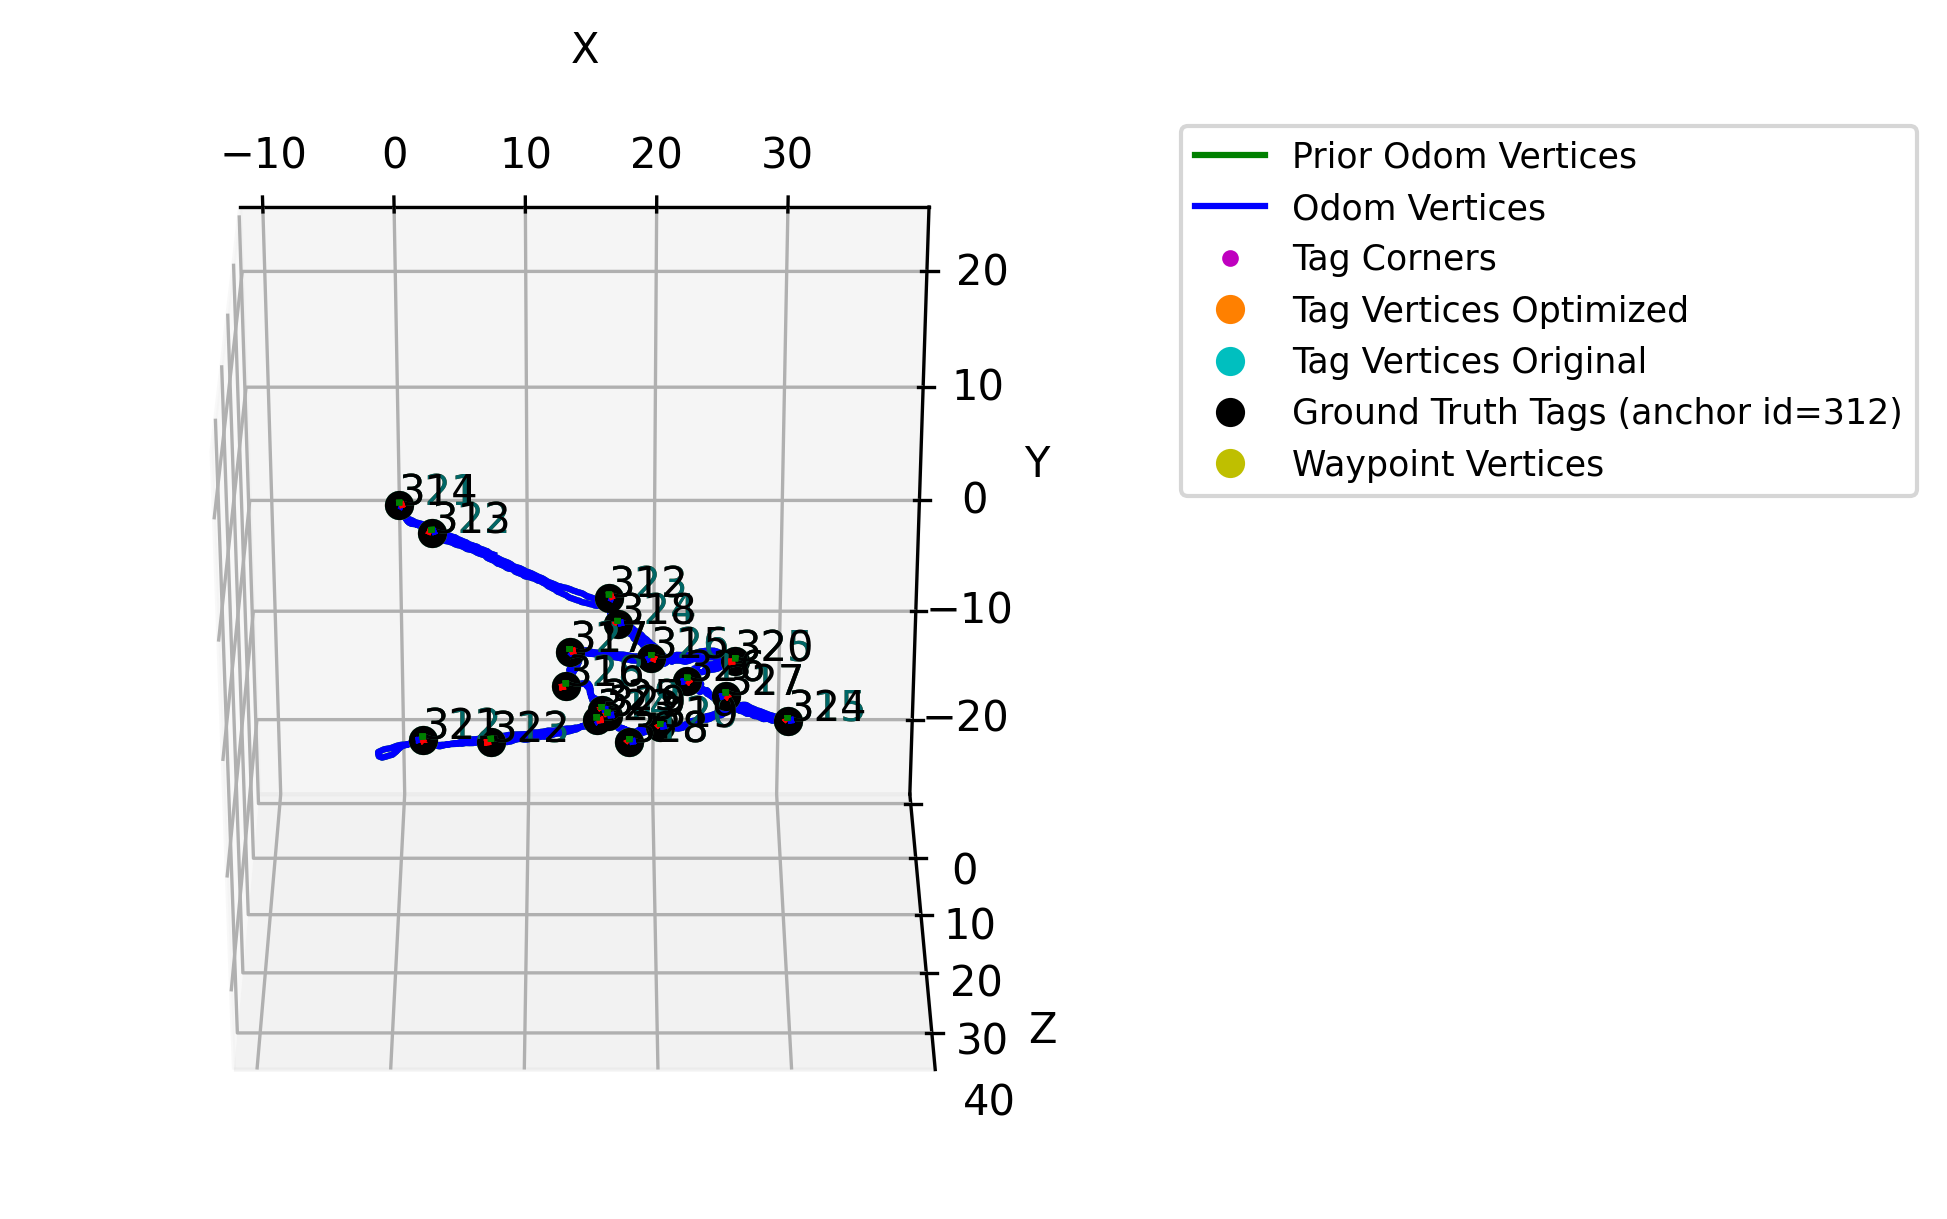

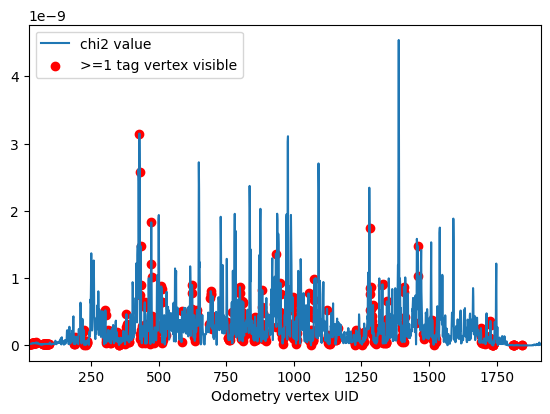

In [4]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=False, generate_plot=False, show_plot=False, num_processes=8)

In [5]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([0, 0, 0]),
    "ang_vel_var": 0,
    "tag_var": 0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")

Ground truth value at parameters approximately equaling the generation parameters: 4.33e-07
Difference with minimum value observed: -3.30e-08


The following is for a small recording of WH4:

In [6]:
small_map_info = CacheManagerSingleton.find_maps(small_data_set_name, search_restriction=0).pop()
small_ug_dataset = UGDataSet(**small_map_info.map_dct)
# Generate a derived data set
data_set_name = small_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     0,
        GenerateParams.OdomNoiseDims.Y:     0,
        GenerateParams.OdomNoiseDims.Z:     0,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=small_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-2, 1e+1, 10]),
}

100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s]


Pre-Optimization GT: 5.546004984440191e-07
Best GT: 2.2876158101564836e-07 (delta: -3.258389174283707e-07
Best Alpha: -59462.61122724715


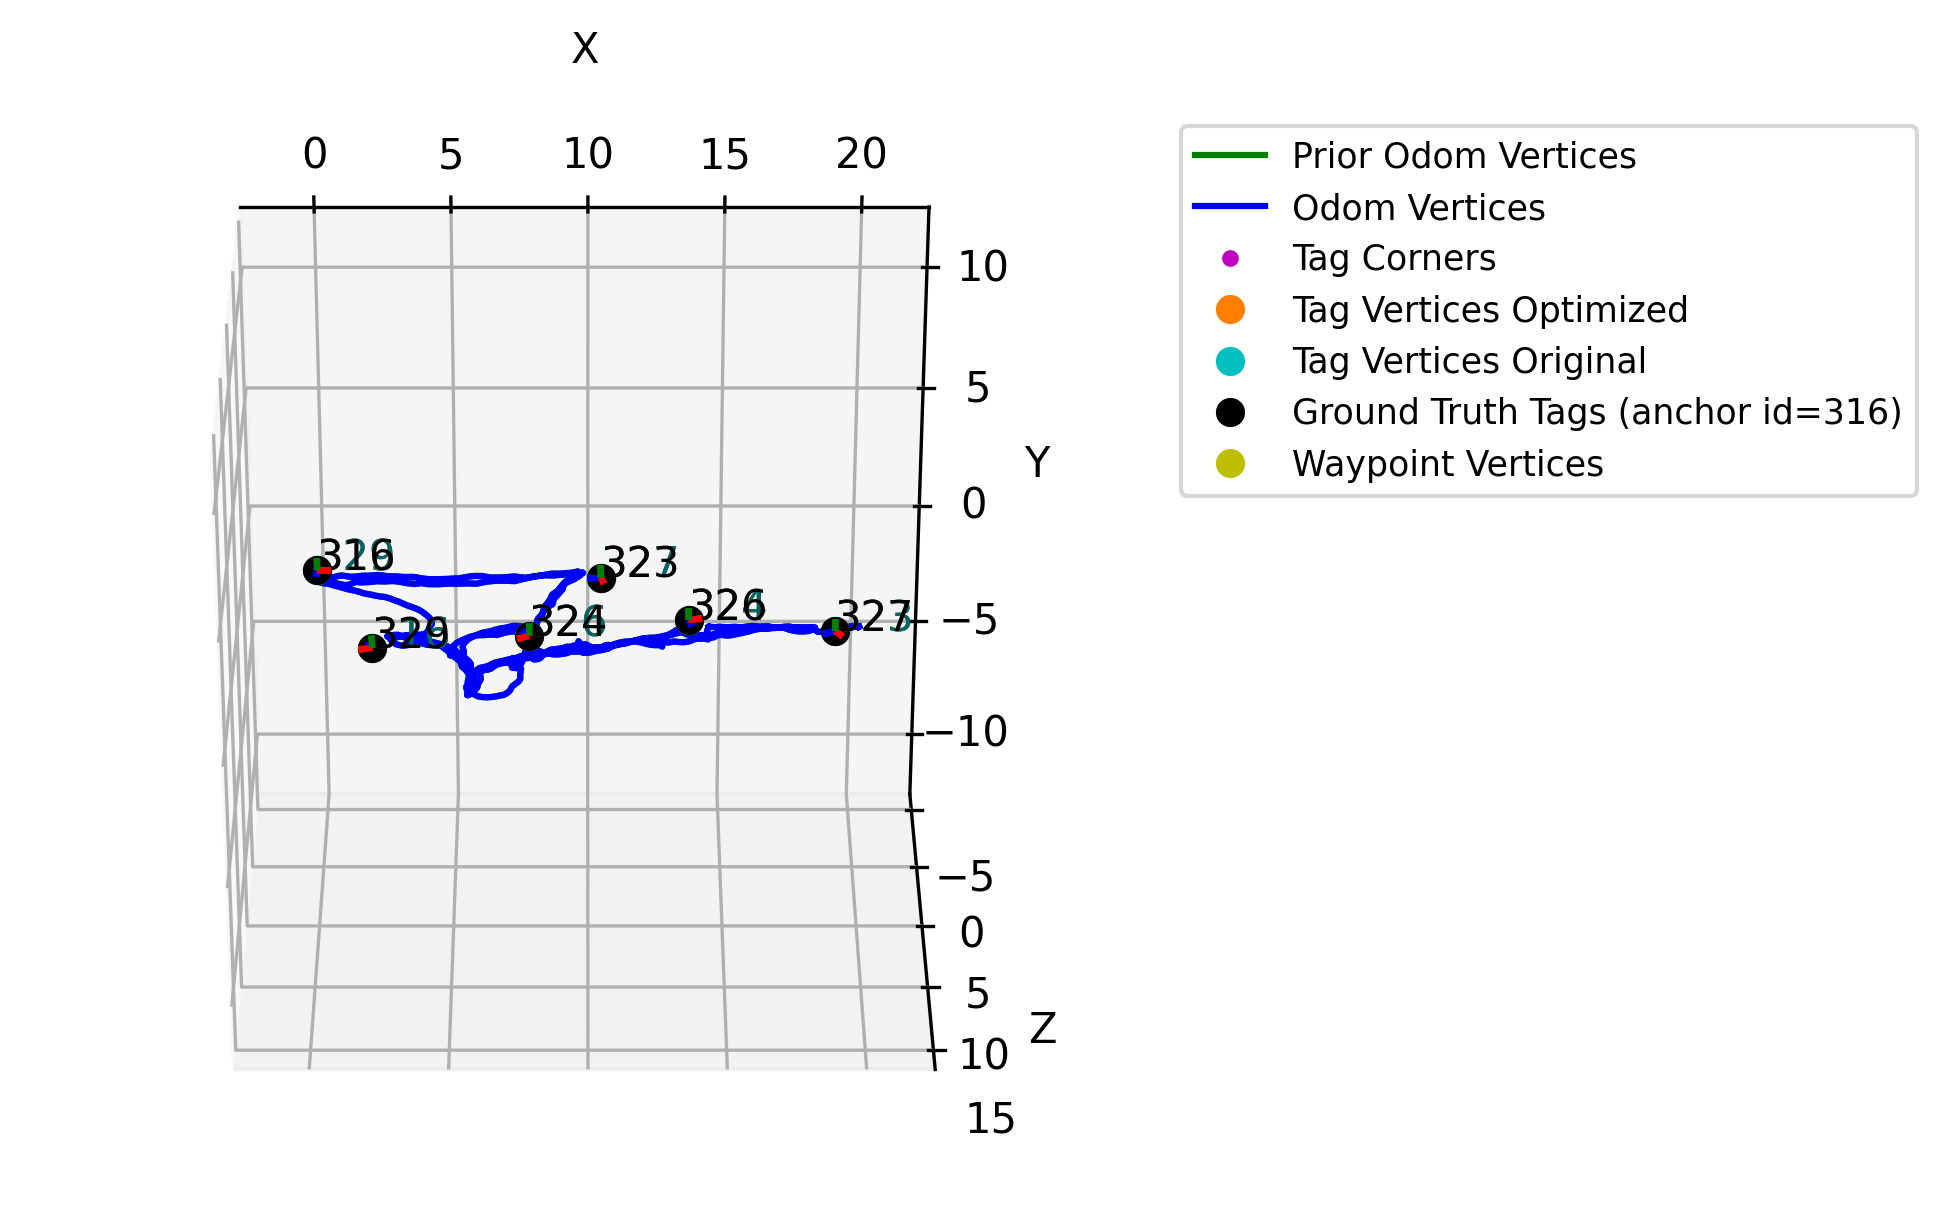

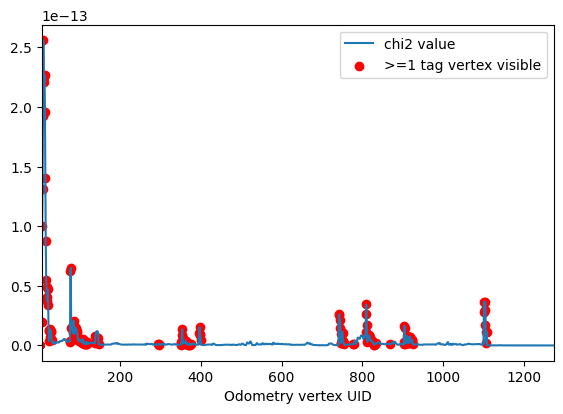

In [7]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=False, generate_plot=False, show_plot=False, num_processes=8)

In [8]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([0, 0, 0]),
    "ang_vel_var": 0,
    "tag_var": 0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")

Ground truth value at parameters approximately equaling the generation parameters: 2.29e-07
Difference with minimum value observed: -4.92e-10


As seen through this run, when zero noise is inputted in the dataset used to configure the map, the ground truth metric (Best GT) by optimizing with these parameters is 5.48e-6. This is almost exactly the same as the GT metric from the graph optimization above. This shows that using parameters that specify 0 noise in both odometry and tag observance to optimize a map that has no variance initially inputted results in almost the same GT metric as when the map is generated by sweeping through parameters.

## Odometry Variance

The second iteration of this experiment ensures that if a certain odometry variance is entered into the dataset, the optimized graph after the parameter sweep has a similar variance. To test for this, a specific odometry variance (variance in X, Y, and Z) is inputted into the data. Then, the data is optimized by running a parameter sweep. The GT value (change in position of the map) would ideally be close to one another if the parameters used to generate the variance in the dataset are used to optimize it.

This is for a large dataset recording of WH4:

In [9]:
large_map_info = CacheManagerSingleton.find_maps(large_data_set_name, search_restriction=0).pop()
large_ug_dataset = UGDataSet(**large_map_info.map_dct)
# Generate a derived data set
data_set_name = large_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     1e-2,
        GenerateParams.OdomNoiseDims.Y:     1e-3,
        GenerateParams.OdomNoiseDims.Z:     1e-2,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=large_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-6, 1e+1, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-3, 1e+1, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-2, 1e+1, 10]),
}

100%|██████████| 1000/1000 [36:23<00:00,  2.18s/it] 


Pre-Optimization GT: 0.04778734736122355
Best GT: 0.015877033816736615 (delta: -0.03191031354448694
Best Alpha: -109324.80822226833


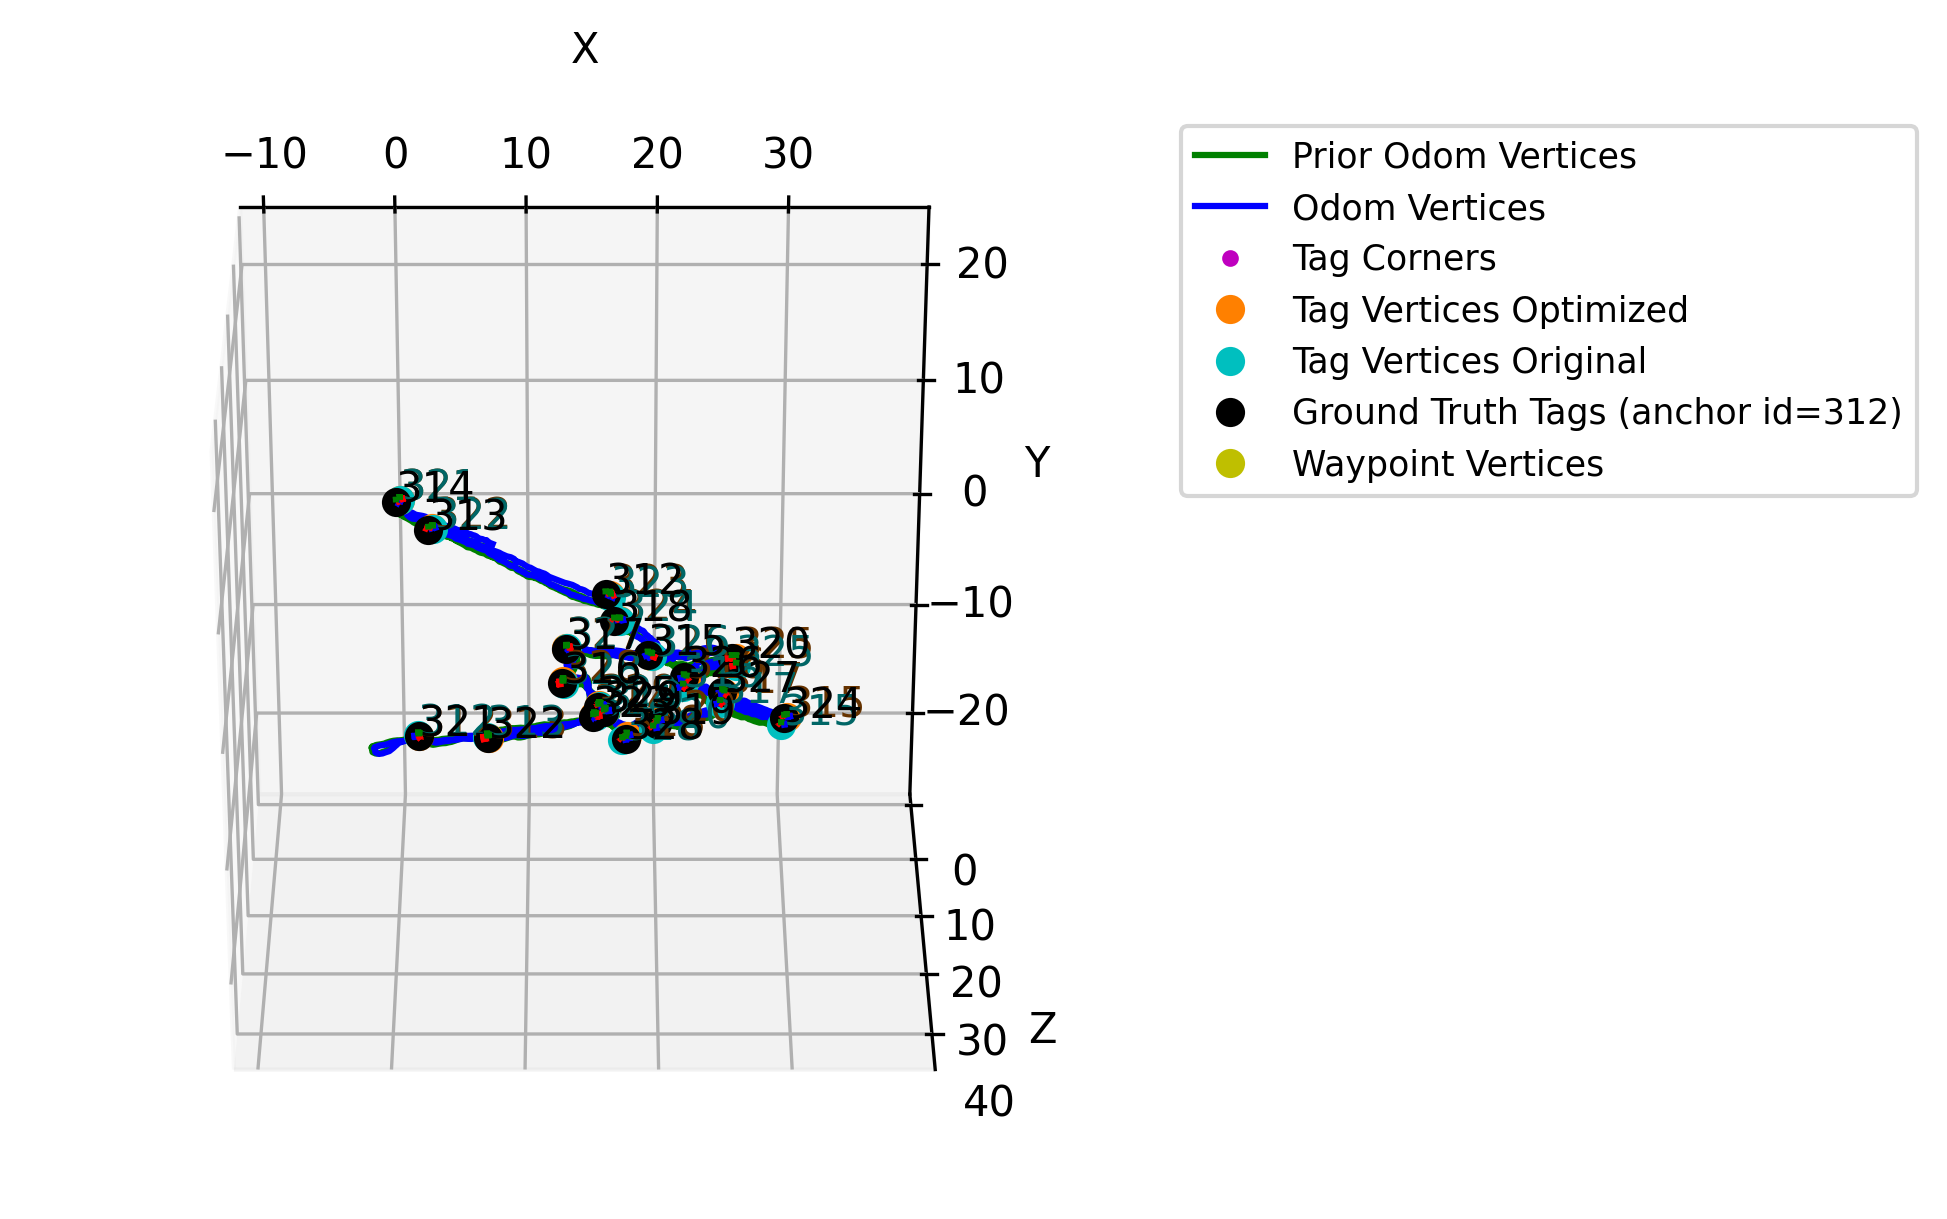

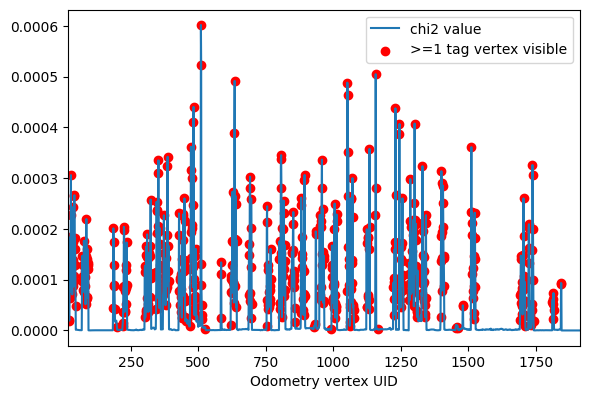

In [10]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=False, generate_plot=False, show_plot=False, num_processes=8)

In [11]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([1e-2, 1e-3, 1e-2]),
    "ang_vel_var": 0,
    "tag_var": 0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")
      

Ground truth value at parameters approximately equaling the generation parameters: 2.91e-02
Difference with minimum value observed: -1.32e-02


This is for a small recording of WH4:

In [12]:
small_map_info = CacheManagerSingleton.find_maps(small_data_set_name, search_restriction=0).pop()
small_ug_dataset = UGDataSet(**small_map_info.map_dct)
# Generate a derived data set
data_set_name = small_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     1e-2,
        GenerateParams.OdomNoiseDims.Y:     1e-3,
        GenerateParams.OdomNoiseDims.Z:     1e-2,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=small_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-6, 1e+1, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-3, 1e+1, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-2, 1e+1, 10]),
}

100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s] 


Pre-Optimization GT: 0.027046428287898234
Best GT: 0.012979814890892094 (delta: -0.01406661339700614
Best Alpha: -72566.49695346085


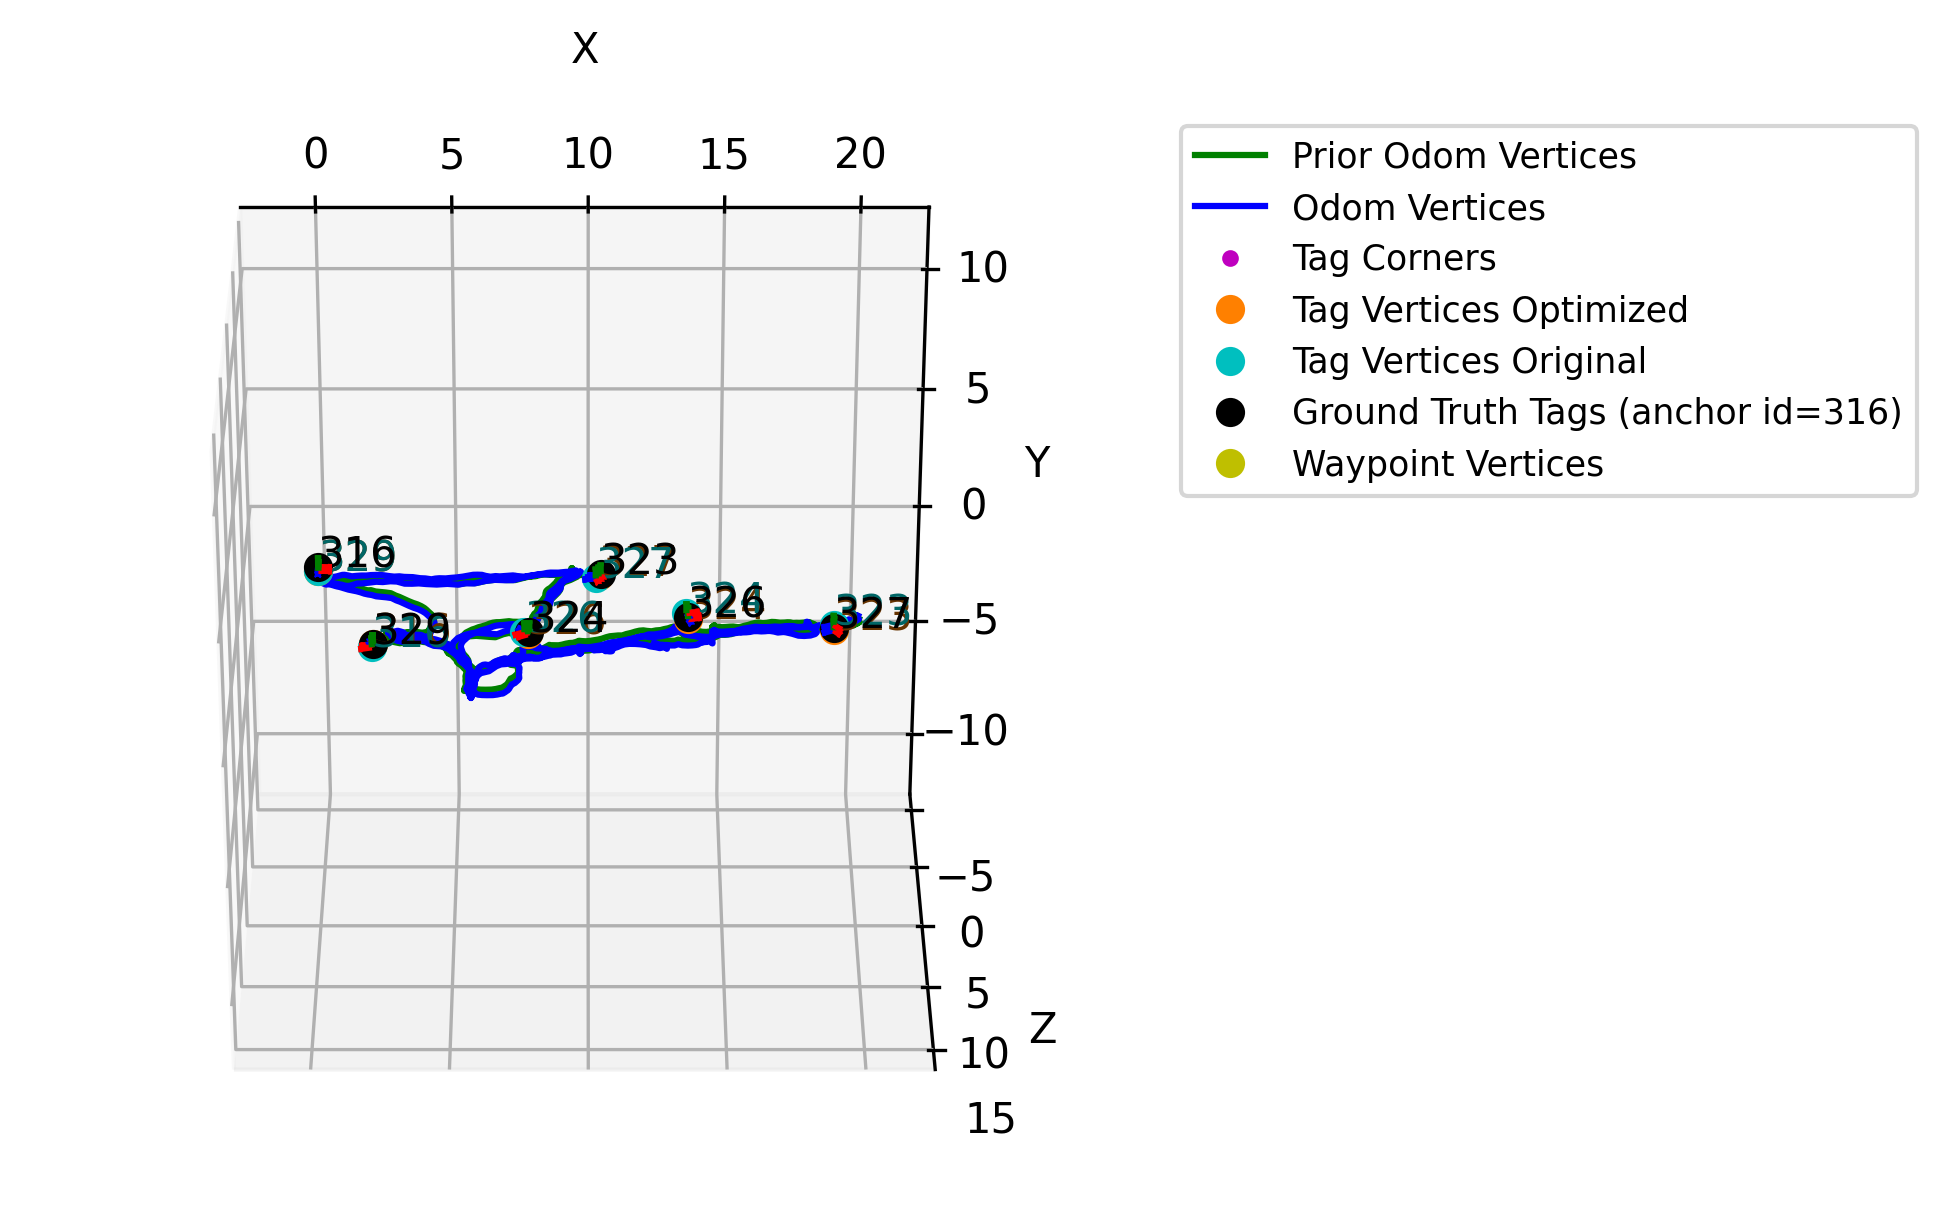

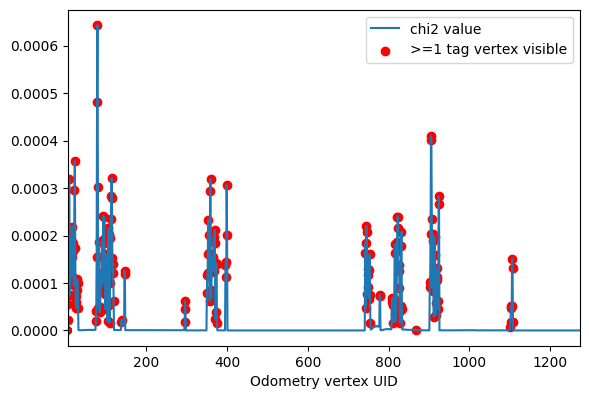

In [13]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=False, generate_plot=False, show_plot=False, num_processes=8)

In [14]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([1e-2, 1e-3, 1e-2]),
    "ang_vel_var": 0,
    "tag_var": 0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")
      

Ground truth value at parameters approximately equaling the generation parameters: 1.91e-02
Difference with minimum value observed: -6.07e-03


Through this run, it is evident that when a certain odometry noise is inputted into the dataset and that same noise is reinserted as a parameter for optimization of the map, the GT value (distance the map has to readjust) is 0.00459, which is 0.00273 away from the GT from the optimized map. 

## Tag Variance

The third iteration of this experiment involves varying just the tag observation variance and performing a similar comparision as before of the GT from the optimized graph after the parameter sweep versus the GT when the variance inputted is used to optimize. The GT value (change in position of the map) would ideally be close to one another if the parameters used to generate the variance in the dataset are used to optimize it.

This is for a large recording of WH4:

In [15]:
large_map_info = CacheManagerSingleton.find_maps(large_data_set_name, search_restriction=0).pop()
large_ug_dataset = UGDataSet(**large_map_info.map_dct)
# Generate a derived data set
data_set_name = large_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=1.0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     0,
        GenerateParams.OdomNoiseDims.Y:     0,
        GenerateParams.OdomNoiseDims.Z:     0,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=large_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-2, 1e+3, 10]),
}


Generating list of optimization sweeping parameters...
1000 parameters generated for sweeping
Starting multi-process optimization parameter sweep (with 8 processes)...


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s] 


Pre-Optimization GT: 0.011507221233898446
Best GT: 0.013458886728258164 (delta: 0.001951665494359718
Best Alpha: -89038.11943735421
Pre-Optimization GT: 0.011507221233898446
For map based on min alpha, GT: 0.01608142430440252 (delta = 0.0045742030705040754)
For map based on min gt, GT: 0.013458886728258164 (delta = 0.001951665494359718)
For map based on min shift, GT: 0.03375886652617784 (delta = 0.022251645292279396)
Min Shift Metric: 0.11895934256818529

 
Fitness metrics (GT): 
>        chi2_all_before: 0.071
>       alpha_all_before: 4.2e+03
> se3_not_gravity_before: 0.071
>          psi2uv_before: 0
>         gravity_before: 2.2e-12
---------------------------------
>         chi2_all_after: 0.064
>        alpha_all_after: 4.2e+03
>  se3_not_gravity_after: 0.064
>           psi2uv_after: 0
>          gravity_after: 5.7e-07

Fitness metrics (Alpha): 
>        chi2_all_before: 2e+03
>       alpha_all_before: -8.9e+04
> se3_not_gravity_before: 2e+03
>          psi2uv_before: 0
>     

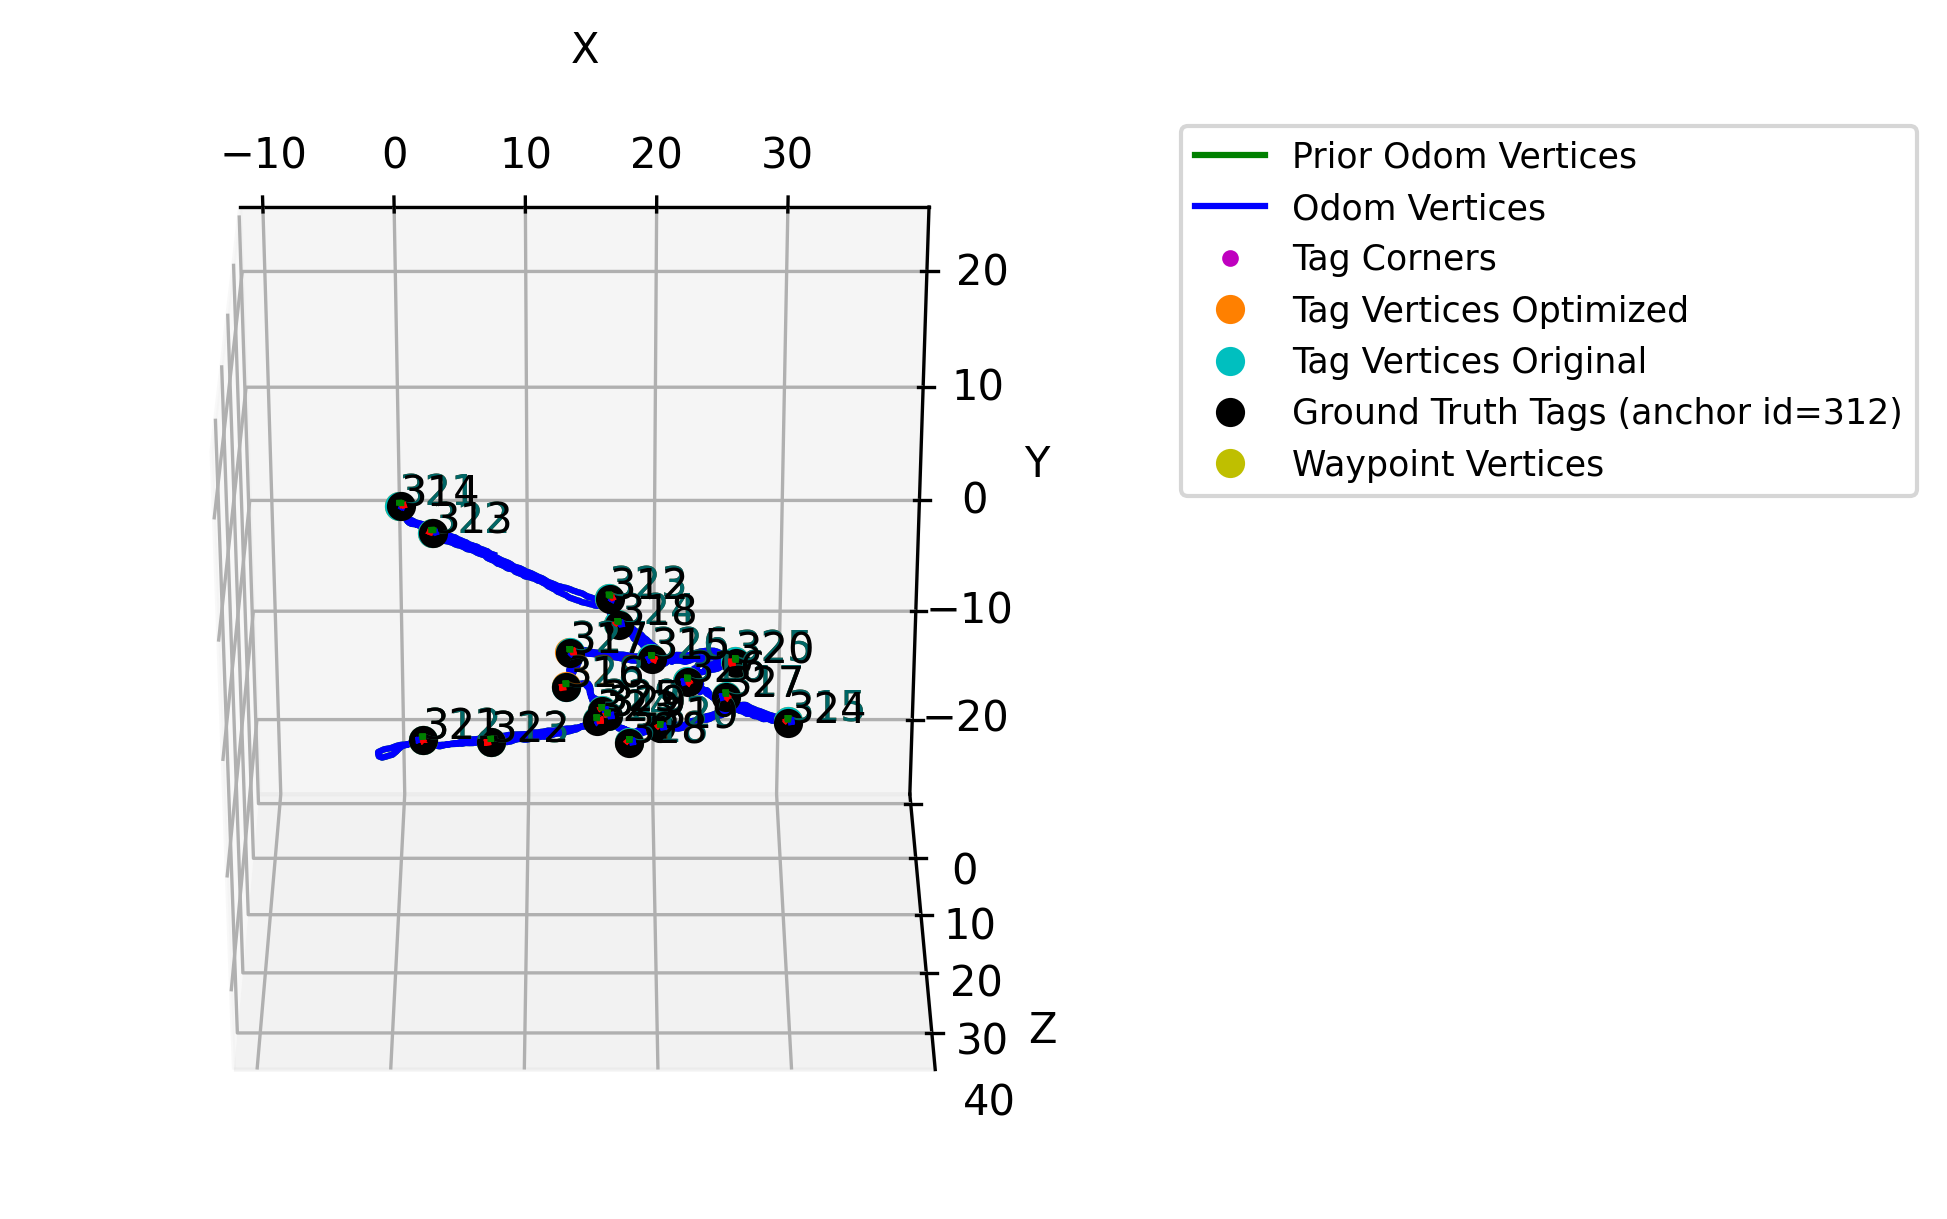

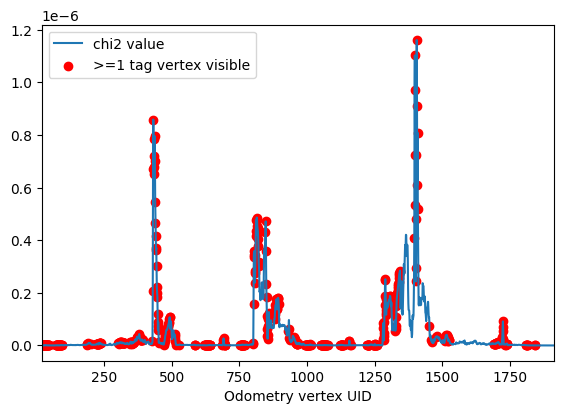

In [16]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
print()
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=True, generate_plot=False, show_plot=False, num_processes=8)

In [17]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([0, 0, 0]),
    "ang_vel_var": 0,
    "tag_var": 1.0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")
      

Ground truth value at parameters approximately equaling the generation parameters: 1.35e-02
Difference with minimum value observed: -3.56e-05


This is for a small recording of WH4:

In [18]:
small_map_info = CacheManagerSingleton.find_maps(small_data_set_name, search_restriction=0).pop()
small_ug_dataset = UGDataSet(**small_map_info.map_dct)
# Generate a derived data set
data_set_name = small_map_info.map_name
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=1.0,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     0,
        GenerateParams.OdomNoiseDims.Y:     0,
        GenerateParams.OdomNoiseDims.Z:     0,
        GenerateParams.OdomNoiseDims.RVERT: 0,
    }
)
gg_sweep = GraphGenerator(path_from=small_ug_dataset, gen_params=gen_params_sweep)
map_info = gg_sweep.export_to_map_processing_cache()
gt_gen_data_set = CacheManagerSingleton.find_ground_truth_data_from_map_info(map_info)

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-4, 1e+1, 10]),
    OConfig.OConfigEnum.TAG_VAR: (np.geomspace, [1e-2, 1e+3, 10]),
}


Generating list of optimization sweeping parameters...
1000 parameters generated for sweeping
Starting multi-process optimization parameter sweep (with 8 processes)...


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


Pre-Optimization GT: 0.25398384040840777
Best GT: 0.03415642975916035 (delta: -0.21982741064924743
Best Alpha: -58968.65637849465
Pre-Optimization GT: 0.25398384040840777
For map based on min alpha, GT: 0.03500288890076909 (delta = -0.2189809515076387)
For map based on min gt, GT: 0.03415642975916035 (delta = -0.21982741064924743)
For map based on min shift, GT: 0.03657490536774735 (delta = -0.21740893504066042)
Min Shift Metric: 0.1847850538887976

 
Fitness metrics (GT): 
>        chi2_all_before: 0.054
>       alpha_all_before: -9.3e+03
> se3_not_gravity_before: 0.054
>          psi2uv_before: 0
>         gravity_before: 1.2e-12
----------------------------------
>         chi2_all_after: 0.0099
>        alpha_all_after: -9.3e+03
>  se3_not_gravity_after: 0.0099
>           psi2uv_after: 0
>          gravity_after: 1.2e-11

Fitness metrics (Alpha): 
>        chi2_all_before: 5.4e+03
>       alpha_all_before: -5.7e+04
> se3_not_gravity_before: 5.4e+03
>          psi2uv_before: 0
>   

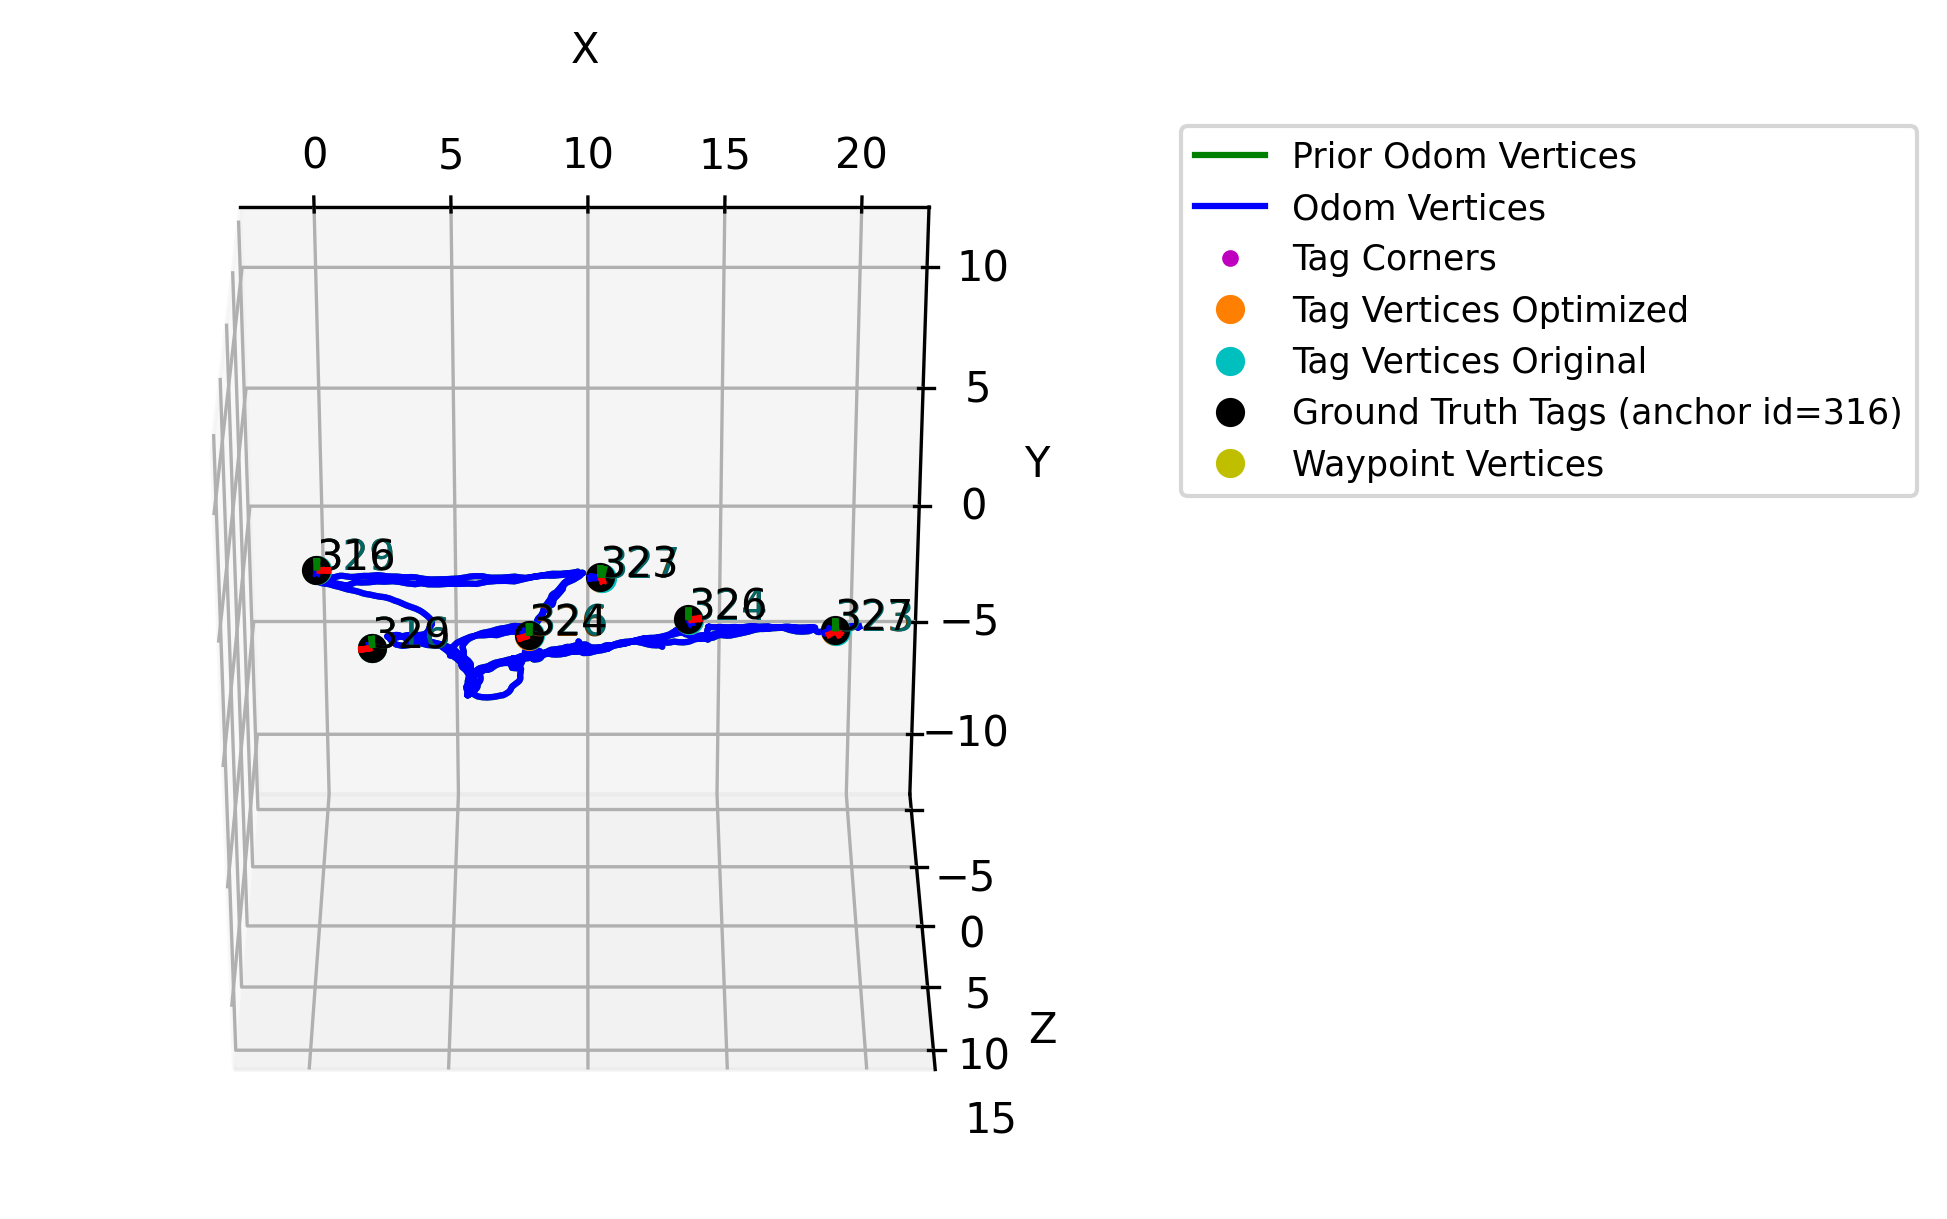

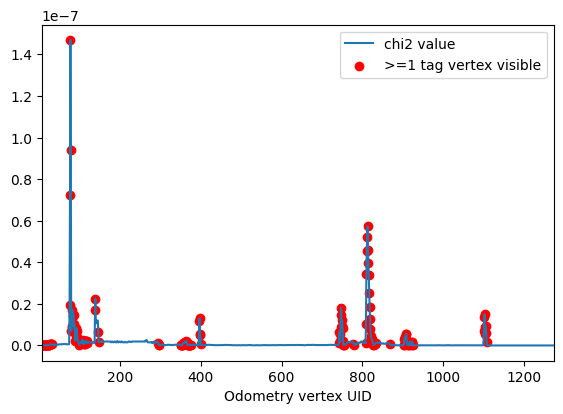

In [19]:
ordered_sweep_config_keys = [key for key in sweep_config.keys()]
print()
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set,
             base_oconfig=OConfig(is_sba=False, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=True, generate_plot=False, show_plot=False, num_processes=8)

In [20]:
# Enter the same zero variance back into the prediction to find gt at this query
query_at_exact = {
    "lin_vel_var": np.linalg.norm([0, 0, 0]),
    "ang_vel_var": 0,
    "tag_var": 1.0
}

value_at_query = osr.query_at(query_at_exact)
print(f"Ground truth value at parameters approximately equaling the generation parameters: "
      f"{value_at_query:.2e}\nDifference with minimum value observed: "
      f"{osr.min_gt_result - value_at_query:.2e}")
      

Ground truth value at parameters approximately equaling the generation parameters: 3.45e-02
Difference with minimum value observed: -3.56e-04


## Comparision

We can compare the difference in GT values when just tag variance is inputted vs when just odometry variance is inputted. 

In this particular case, when a specific odometry variance was used as the parameter to optimize the map, the GT metric was 0.00313, which was 0.00301 different than the GT metric if a parameter sweep were to be run on the data to optimize the map. 

In the case of tag variance, when a specific tag variance was used as the parameter to optimize the map, the GT metric was 0.0912, which was exactly the same as the GT when the parameter sweep was used to optimize the map.

It can be concluded that although tag variance has a greater impact on GT value (the overall number was larger), odometry variance appears to lead to a slight difference in inputted vs outputted variance. One potential cause for this could be the parameter sweep steps being too large or not covering enough parameters.